In [1]:
# %load /home/vpoduri/standard_imports.py
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn import datasets,metrics,naive_bayes,tree,svm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score,cross_validate


from matplotlib import pyplot as plt

import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.plotting.backend = "plotly"


# Datasets

## Scikit-learn datasets

See [scikit-learn datasets page](https://scikit-learn.org/stable/datasets.html) for details.

In [2]:
diab = datasets.load_diabetes(as_frame=True)

In [3]:
print(diab.DESCR)   # Description says that the features are already standardized.

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

## UCI ML repository data

In [4]:
# Heart disease Cleveland data: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

In [5]:
ColNames = ['age','sex','cp','trestbps','chol','fbs','restecg',
            'thalach','exang','oldpeak','slope','ca','thal','num'] # Num is the class. Other columns are features.  

# See cell above for description 

In [6]:
HDData = pd.read_csv('processed.cleveland.data',header=None,names=ColNames)

# Processing

## Missing values

In [7]:
# Need to decide what to do with missing values. Needs some domain knowledge.
# Here we choose default values based on reasonable guesses, but this is arbitrary.

# ca: number of major vessels (0-3) colored by flouroscopy
# thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

VDefaults = {'ca':0, 'thal':3}
for k,v in VDefaults.items():
    s = HDData[k].replace('?',np.NaN).astype(float)
    HDData[k] = (np.where(s.notna(),s,v)).astype(int)


## Encoding

In [8]:
# DataDF = diab.frame
# # We discretize the disease progression variable to obtain 4 classes.
# DataDF["target"] = pd.cut(DataDF["target"],4,labels=["Low","Medium","High","Severe"])  # classes

In [9]:
# Categorical variables: encode as integers
CatVars = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
for col in CatVars:
    HDData[col] = HDData[col].astype(int)

Is one-hot encoding needed?

In [10]:
# From the documentation:
# The "goal" field refers to the presence of heart disease
# in the patient.  It is integer valued from 0 (no presence) to 4.
# Experiments with the Cleveland database have concentrated on simply
# attempting to distinguish presence (values 1,2,3,4) from absence (value 0)

HDData["target"] = np.where(HDData["num"]>0,1,HDData["num"])
#HDData.drop(columns=["num"],inplace=True)

## Standardization

In [11]:
FloatVars = HDData.columns.difference(CatVars+["target"])
for v in FloatVars:
    m,s = HDData[v].mean(),HDData[v].std()
    HDData[v] = (HDData[v]-m)/s

## Visualizing distributions

Particularly important to see the distribution of classes

In [12]:
HDData["target"].value_counts()
#px.histogram(HDData,x="num")

#px.histogram(x=HDData["chol"],marginal="box") # Good way of seeing outliers along side distribution

0    164
1    139
Name: target, dtype: int64

In [33]:
# Features = HDData.drop(columns=['num']).melt(var_name='Feature',value_name='Value',ignore_index=False)
# px.histogram(Features,x="Value",facet_col="Feature",facet_col_wrap=3).update_layout(height=900)


PlotVars = HDData.columns.difference(["sex","num","target"])
ncols = 3
nrows = int(np.ceil(len(PlotVars)/ncols))
fig = make_subplots(rows=nrows, cols=ncols,subplot_titles=PlotVars)

for i,var in enumerate(PlotVars):
    plotrow = int(np.floor((i/ncols)+1))
    plotcol = np.mod(i+1,ncols)
    if plotcol == 0: plotcol=ncols
    _ = fig.add_trace(go.Histogram(x=HDData[var]),row=plotrow, col=plotcol)
fig.update_layout(height=900,showlegend=False)

## Data splitting

In [14]:
def SplitData(df,yvar = "target",train_f = 3/4):
    '''
    Splits data into training and testing subsets
    Arguments:
        df: pandas dataframe containing the data
        train_f: fraction to be used for training
    Returns dictionary with keys ['XTrain','yTrain','XTest','yTest'] and values with corresponding arrays   
    '''
    
    DFDict = {}
    DFDict['Train'] = df.sample(int(np.ceil(train_f*df.shape[0])))
    DFDict['Test'] = df.loc[df.index.difference(DFDict['Train'].index),:].reset_index(drop=True)
    DFDict['Train'] = DFDict['Train'].reset_index(drop=True)
    
    DataArrays = {}
    XCols = df.columns.difference([yvar])
    for type in ['Train','Test']:
        DataArrays['X'+type] = DFDict[type][XCols].values
        DataArrays['y'+type] = DFDict[type][yvar].values
                                                  
    return(DataArrays) 

In [34]:
DA = SplitData(HDData.drop(columns=["num"])) # Data arrays
X,y = DA['XTrain'],DA['yTrain']

actuals = DA['yTest']

# Classification metrics

Classification metrics can be understood with reference to what is known as a "confusion matrix" which shows the counts
in the various cells of the table below. Here, TP and TN stand for "True Positive" and "True Negative", while FP and FN stand for "False Positive" and "False Negative".

| &nbsp; | &nbsp; | &nbsp;|
| --- | --- | --- |
| &nbsp; | Predicted Positive | Predicted Negative |
| Actual Positive | TP | FN |
| Actual Negative | FP | TN |

Some useful metrics are defined as follows:
$$
\begin{split}
\textrm{Accuracy} &= \frac{TP+TN}{TP+TN+FP+FN}\\
\textrm{Precision} &= \frac{TP}{TP+FP}\\
\textrm{Recall} &= \frac{TP}{TP+FN}
\end{split}
$$

The Accuracy metric represents the fraction of total observations that the classifier gets right. Precision and Recall capture other aspects of the matrix. As a mnemonic, we cant hink of a diagnostic test for a disease. Then

$$
\begin{split}
\textrm{Precision = probability that a positive test is correct}\\
\textrm{Recall = probability that the test "catches" the disease}
\end{split}
$$

In [35]:
def cmDF(actuals,yhat):
    cm = metrics.confusion_matrix(actuals,yhat)
    DF = pd.DataFrame(cm,index=[0,1],columns=[0,1])
    DF.rename_axis(index='Actual',columns='Predicted',inplace=True)
#     np.sum((actuals==0) & (yhat==actuals))    # check numbers
    TN,FP,FN,TP = cm.ravel()                  # For Precision, Recall, ROC etc
    accuracy = (TP+TN)/cm.sum()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    return({'Confusion Matrix':DF,'Accuracy':accuracy,'Precision':precision,'Recall':recall})

# Cross Validation

In $K$-fold validation, the training set is split into $K$ subsets, a model is trained on $K-1$ subsets and evaluated on the remaining subset. This is repeated for each of the subsets.

In [36]:
def cvDF(clf,X,y,cv=10,measures=['accuracy','precision','recall']):
    '''
    Runs cross validation with 'cv' folds and returns mean and sd
    of measures as a pandas DataFrame    
    '''
    scores3 = cross_validate(clf,X,y,scoring=measures,cv=cv)
    d = {'Metric':[str.title(x) for x in measures],'Mean':[],'SD':[]}
    d['Metric'] = [str.title(x) for x in measures]
    for m in measures:
        k = 'test_'+m
        d['Mean'].append(scores3[k].mean())
        d['SD'].append(scores3[k].std())
    return (pd.DataFrame(d))

# Classifiers

From the [documentation](https://scikit-learn.org/stable/tutorial/statistical_inference/settings.html)

> Fitting data: the main API implemented by scikit-learn is that of the estimator. An estimator is any object
> that learns from data; it may be a classification, regression or clustering algorithm or a transformer that
> extracts/filters useful features from raw data.

> All estimator objects expose a fit method that takes a dataset (usually a 2-d array):

## k Nearest Neighbors

The idea of the k Nearest Neighbors classification is really simple. For each test sample, we find the set of $k$ observations in the training data that are closest to the test sample (nearest neighbors). The predicted class of the test sample is then the most common class among the $k$ nearest neighbors.

This can be extended to "regression", when the predicted value of an attribute of interest for the test sample is the average value of the same attribute for the $k$ nearest neighbors.

The hyperparameters in this case are $k$, the number of nearest neighbors to look for, and the method used to determine which training  observations are closest to the test sample (the distance metric).

In [37]:
knn = KNeighborsClassifier()     # Instantiate a classifier object
#knn.get_params()                 # Default parameters

print("\n 10-fold cross validation")
with pd.option_context('display.float_format','{:.2f}'.format):
    cvDF(knn,X,y)

_=knn.fit(X,y)                   # Train the classifier on all training data

yhat = knn.predict(DA['XTest'])
print("\n Performance on test data")
cm = cmDF(actuals,yhat)
for k,v in cm.items():
    k,round(v,2)


 10-fold cross validation


,Metric,Mean,SD
0,Accuracy,0.80,0.08
1,Precision,0.79,0.12
2,Recall,0.73,0.16



 Performance on test data


('Confusion Matrix',
 Predicted   0   1
 Actual           
 0          32   3
 1          16  24)

('Accuracy', 0.75)

('Precision', 0.89)

('Recall', 0.6)

## Naive Bayes

Let $\boldsymbol{x} = \{x_1,x_2,\cdots,x_p\}$ be a vector of features and let $y$ be the class variable that can take on one of the values in the set $\{y_i\}$. Then, from Bayes' rule, we have

$$
P(y=y_i|\boldsymbol{x}) = \frac{P(\boldsymbol{x}|y=y_i) \cdot P(y=y_i)}{P(\boldsymbol{x})}
$$

The "naive" assumption is that the features are conditionally independent:

$$
P(\boldsymbol{x}|y=y_i) = P(x_1,x_2,\cdots,x_p|y=y_i) = P(x_1|y=y_i) P(x_2|y=y_i) \cdots P(x_p|y=y_i)
$$

With this assumption, 

$$
P(y=y_i|\boldsymbol{x}) = \frac{ P(y=y_i) \Pi_j P(x_j|y=y_i) }{P(\boldsymbol{x})}
$$

Noting that the denominator $P(\boldsymbol{x})$ is independent of the class, we arrive at a **decision rule** for the predicted class $\hat{y}$ given a set of features $\boldsymbol{x}$:

$$
\hat{y} = \arg\max_{y_i} P(y=y_i) \Pi_j P(x_j|y=y_i) 
$$

The class probabilities $P(y=y_i)$ can be inferred from the training data. Conditional feature probabilities $P(x_j|y=y_i)$  are model-based. One common model is to assume that $P(x_j|y=y_i)$ is Gaussian, with the mean and variance estimated from the training data. 

In [38]:
gnb = naive_bayes.GaussianNB()

print("\n 10-fold cross validation")
with pd.option_context('display.float_format','{:.2f}'.format):
    cvDF(gnb,X,y)
    
gnbfit = gnb.fit(X,y)       # All training data
 
yhat = gnbfit.predict(DA['XTest'])
print("\n Performance on test data")
cm = cmDF(actuals,yhat)
for k,v in cm.items():
    k,round(v,2)



 10-fold cross validation


,Metric,Mean,SD
0,Accuracy,0.84,0.09
1,Precision,0.84,0.12
2,Recall,0.80,0.13



 Performance on test data


('Confusion Matrix',
 Predicted   0   1
 Actual           
 0          32   3
 1          11  29)

('Accuracy', 0.81)

('Precision', 0.91)

('Recall', 0.72)

## Logistic Regression

When the dependent variable $Y \in [0,1]$, the regression model is

$$
 p = E(Y|\boldsymbol{\beta}) = h(\boldsymbol{X\beta})
$$

where $p$ is the probability that $Y=1$ and $h: \mathbb{R} \to [0,1]$. This is called a **generalized linear model**. Examples are:

\begin{split}
h(x) &= \frac{1}{1+e^{-x}} \qquad \textbf{logit model}\\
h(x) & = \Phi(x) \qquad \textbf{probit model}
\end{split}

**Estimation of $\boldsymbol{\beta}$**

The dependent variable $Y$ is given by the Bernoulli distribution

$$
P(Y=y) = p^y(1-p)^{1-y} \qquad y \in [0,1]
$$

where $p$ is the probability that $Y=1$.

The likelihood function assuming $n$ independent observations is

$$
L = \Pi_{i=1}^n {p_i}^{y_i} (1-p_i)^{1-y_i}
$$

The log likelihood function $\mathcal{L} = \ln (L)$ is given by

\begin{split}
\mathcal{L} &= \sum_i y_i \ln(p_i) + (1-y_i)\ln(1-p_i)\\
            &= \sum_i y_i \ln[h(\boldsymbol{X\beta})] + (1-y_i)\ln[1-h(\boldsymbol{X\beta})]
\end{split}

$\boldsymbol{\beta}$ can be found by numerical maximization of $\mathcal{L}$.

In [39]:
lreg = LogisticRegression(random_state=1)

print("\n 10-fold cross validation")
with pd.option_context('display.float_format','{:.2f}'.format):
    cvDF(lreg,X,y)

_ = lreg.fit(X,y)          # Using all training data
yhat = lreg.predict(DA['XTest'])
print("\n Performance on test data")
cm = cmDF(actuals,yhat)
for k,v in cm.items():
    k,round(v,2)


 10-fold cross validation


,Metric,Mean,SD
0,Accuracy,0.83,0.09
1,Precision,0.84,0.12
2,Recall,0.76,0.14



 Performance on test data


('Confusion Matrix',
 Predicted   0   1
 Actual           
 0          33   2
 1           8  32)

('Accuracy', 0.87)

('Precision', 0.94)

('Recall', 0.8)

## Decision Tree

In [60]:
DTC = tree.DecisionTreeClassifier(max_depth=3,random_state=1)

print("\n 10-fold cross validation")
with pd.option_context('display.float_format','{:.2f}'.format):
    cvDF(lreg,X,y)

DTC.fit(X,y)                  # fit using all training data
yhat = DTC.predict(DA['XTest'])

print("\n Performance on test data")
cm = cmDF(actuals,yhat)
for k,v in cm.items():
    k,round(v,2)


 10-fold cross validation


,Metric,Mean,SD
0,Accuracy,0.83,0.09
1,Precision,0.84,0.12
2,Recall,0.76,0.14


DecisionTreeClassifier(max_depth=3, random_state=1)


 Performance on test data


('Confusion Matrix',
 Predicted   0   1
 Actual           
 0          31   4
 1          18  22)

('Accuracy', 0.71)

('Precision', 0.85)

('Recall', 0.55)

**Visualization**

- Left branch when condition in node is true
- Samples: number of instances the node considers
- gini: Gini impurity, $G = 1 - \sum_k p_k^2$  where $p_k$ is the fraction of class $k$ instances in the samples
- value: list of number of instances of each class
- class: most frequent class in list value

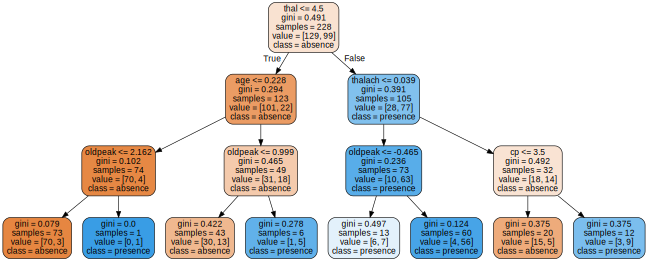

In [42]:
import graphviz
import pydotplus

# sklearn visualizer
# fig = plt.figure(figsize=(25,20))
features = HDData.columns.difference(["num","target"])
# _ = tree.plot_tree(DTC, 
#                    feature_names=features,  
#                    class_names=["absence","presence"],
#                    filled=True)


# graphviz visualizer is better
dot_data = tree.export_graphviz(DTC, out_file=None, 
                     feature_names=features,  
                     class_names=["absence","presence"],  
                     filled=True, rounded=True,)  
graph = graphviz.Source(dot_data)  
#graph

# Resizing the plot, from https://stackoverflow.com/a/51351199
# Weird black shaded box can be removed by removing a '/n' near the end of 'dot_data'

dot_data = dot_data[:-2]+''+dot_data[-1:]   
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"9,12!"')
graphviz.Source(pydot_graph.to_string())

## Support Vector Machine

In [43]:
svc1 = svm.SVC(kernel='linear')
svc2 = svm.SVC(kernel='poly')
svc3 = svm.SVC(kernel='rbf')

print("\n 10-fold cross validation")
for m in [svc1,svc2,svc3]:
    print("SVM with ",m.kernel," kernel")
    with pd.option_context('display.float_format','{:.2f}'.format):
        cvDF(m,X,y)

print("\n Performance on test data")
for m in [svc1,svc2,svc3]:
    _=m.fit(X,y)
    print("SVM with ",m.kernel," kernel")
    yhat = m.predict(DA['XTest'])
    cm = cmDF(actuals,yhat)
    for k,v in cm.items():
        k,round(v,2)


 10-fold cross validation
SVM with  linear  kernel


,Metric,Mean,SD
0,Accuracy,0.83,0.11
1,Precision,0.84,0.14
2,Recall,0.76,0.16


SVM with  poly  kernel


,Metric,Mean,SD
0,Accuracy,0.83,0.07
1,Precision,0.88,0.11
2,Recall,0.72,0.15


SVM with  rbf  kernel


,Metric,Mean,SD
0,Accuracy,0.83,0.07
1,Precision,0.86,0.10
2,Recall,0.73,0.14



 Performance on test data
SVM with  linear  kernel


('Confusion Matrix',
 Predicted   0   1
 Actual           
 0          33   2
 1          10  30)

('Accuracy', 0.84)

('Precision', 0.94)

('Recall', 0.75)

SVM with  poly  kernel


('Confusion Matrix',
 Predicted   0   1
 Actual           
 0          33   2
 1          13  27)

('Accuracy', 0.8)

('Precision', 0.93)

('Recall', 0.68)

SVM with  rbf  kernel


('Confusion Matrix',
 Predicted   0   1
 Actual           
 0          33   2
 1          11  29)

('Accuracy', 0.83)

('Precision', 0.94)

('Recall', 0.72)

## Neural network

In [44]:
NN = MLPClassifier(hidden_layer_sizes=(5,3),solver='lbfgs',max_iter=500,random_state=1)

print("\n 10-fold cross validation")
with pd.option_context('display.float_format','{:.2f}'.format):
        cvDF(NN,X,y)

print("\n Performance on test data")
NN.fit(X,y)
yhat = NN.predict(DA['XTest'])
cm = cmDF(actuals,yhat)
for k,v in cm.items():
    k,round(v,2)


 10-fold cross validation


,Metric,Mean,SD
0,Accuracy,0.80,0.10
1,Precision,0.76,0.11
2,Recall,0.78,0.17



 Performance on test data


MLPClassifier(hidden_layer_sizes=(5, 3), max_iter=500, random_state=1,
              solver='lbfgs')

('Confusion Matrix',
 Predicted   0   1
 Actual           
 0          31   4
 1          11  29)

('Accuracy', 0.8)

('Precision', 0.88)

('Recall', 0.72)

In [45]:
print("Comparing Solvers\n",50*'-')
for smethod in ['lbfgs', 'sgd', 'adam']:
    NN2 = MLPClassifier(hidden_layer_sizes=(5,3),solver=smethod,max_iter=2000,random_state=1)
    _ = NN2.fit(X,y)
    yhat = NN2.predict(DA['XTest'])
    accuracy = metrics.accuracy_score(actuals,yhat)
    print(smethod,accuracy)
    
print("\nComparing Activation Functions\n",50*'-')    
for activ in ['identity','logistic','tanh','relu']:
    NN3 = MLPClassifier(hidden_layer_sizes=(5,3),activation=activ,solver='lbfgs',max_iter=2000,random_state=1)
    _ = NN3.fit(X,y)
    yhat = NN3.predict(DA['XTest'])
    accuracy = metrics.accuracy_score(actuals,yhat)
    print(activ,accuracy)
    
# Using 'lbfgs' and 'relu' activation (default) results in faster convergence.    

Comparing Solvers
 --------------------------------------------------
lbfgs 0.8
sgd 0.8266666666666667
adam 0.8266666666666667

Comparing Activation Functions
 --------------------------------------------------
identity 0.8666666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



logistic 0.68
tanh 0.7733333333333333
relu 0.8


# Comparing multiple classifiers

In [61]:
Classifiers = {'KNN': knn, 'Naive Bayes':gnb,'Logistic Regression':lreg,
              'Decision Tree':DTC, 'SVM Linear': svc1,'SVM Polynomial': svc2,
              'SVM RBF': svc3, 'Neural Network':NN}

results = {'Classifier':[],'Accuracy':[],'Precision':[],'Recall':[]}
for name,clf in Classifiers.items():
    _ = clf.fit(X,y)
    yhat = clf.predict(DA['XTest'])
    cm = cmDF(actuals,yhat)
    results['Classifier'].append(name)
    for k,v in cm.items():
        if k != 'Confusion Matrix':
            results[k].append(round(v,2))  

print("Heart Disease Cleveland data")
print("Training data: ",X.shape[0], " observations")
print("Test data: ",actuals.shape[0], " observations")
print ("Performance on Test data")
pd.DataFrame(results).sort_values("Accuracy",ascending=False).reset_index(drop=True)
print("\nAccuracy = (TP+TN)/(# of observations)")
print("Precision = TP/(TP+FP)")
print("Recall = TP/(TP+FN)")

Heart Disease Cleveland data
Training data:  228  observations
Test data:  75  observations
Performance on Test data


,Classifier,Accuracy,Precision,Recall
0,Logistic Regression,0.87,0.94,0.80
1,SVM Linear,0.84,0.94,0.75
2,SVM RBF,0.83,0.94,0.72
3,Naive Bayes,0.81,0.91,0.72
4,SVM Polynomial,0.80,0.93,0.68
5,Neural Network,0.80,0.88,0.72
6,KNN,0.75,0.89,0.60
7,Decision Tree,0.71,0.85,0.55



Accuracy = (TP+TN)/(# of observations)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)


## With Cross Validation

In [62]:
for i, (name,clf) in enumerate(Classifiers.items()):
    cvstats = cvDF(clf,X,y).set_index("Metric").T
    df = pd.concat({name:cvstats})
    if i==0:
        results = df
    else:
        results = pd.concat([results,df])
        
print("\n 10-fold cross validation")
with pd.option_context('display.float_format','{:.2f}'.format):
        results


 10-fold cross validation


Metric                    Accuracy  Precision  Recall
KNN                 Mean      0.80       0.79    0.73
                    SD        0.08       0.12    0.16
Naive Bayes         Mean      0.84       0.84    0.80
                    SD        0.09       0.12    0.13
Logistic Regression Mean      0.83       0.84    0.76
                    SD        0.09       0.12    0.14
Decision Tree       Mean      0.74       0.71    0.68
                    SD        0.09       0.12    0.15
SVM Linear          Mean      0.83       0.84    0.76
                    SD        0.11       0.14    0.16
SVM Polynomial      Mean      0.83       0.88    0.72
                    SD        0.07       0.11    0.15
SVM RBF             Mean      0.83       0.86    0.73
                    SD        0.07       0.10    0.14
Neural Network      Mean      0.80       0.76    0.78
                    SD        0.10       0.11    0.17

# Ensemble methods

## Voting Classifier

We use an ensemble of classifiers and their majority vote to classify the test cases.

In [63]:
from sklearn.ensemble import VotingClassifier

CSubset = {k:Classifiers[k] for k in ['KNN','Naive Bayes','Logistic Regression',
                                      'Decision Tree']}

cList = [(k,v) for k,v in CSubset.items()]
E1 = VotingClassifier(estimators=cList,voting='hard')
CSubset['Voting Classifer'] = E1

In [65]:
results = {'Classifier':[],'Accuracy':[],'Precision':[],'Recall':[]}
for name,clf in CSubset.items():
    _ = clf.fit(X,y)
    yhat = clf.predict(DA['XTest'])
    cm = cmDF(actuals,yhat)
    results['Classifier'].append(name)
    for k,v in cm.items():
        if k != 'Confusion Matrix':
            results[k].append(round(v,2))
            
# print("Heart Disease Cleveland data")
# print("Training data: ",X.shape[0], " observations")
# print("Test data: ",actuals.shape[0], " observations")
# print ("Performance on Test data")
pd.DataFrame(results).sort_values("Accuracy",ascending=False).reset_index(drop=True)


,Classifier,Accuracy,Precision,Recall
0,Logistic Regression,0.87,0.94,0.80
1,Naive Bayes,0.81,0.91,0.72
2,Voting Classifer,0.79,0.93,0.65
3,KNN,0.75,0.89,0.60
4,Decision Tree,0.71,0.85,0.55


## Bagging

**Bagging** bootstrap aggregating. Sampling training data with replacement

**Pasting** sampling without replacement

In [66]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(lreg,n_estimators=500,max_samples=100,bootstrap=True)


print("\n Performance on test data")
bag.fit(X,y)
yhat = bag.predict(DA['XTest'])
cm = cmDF(actuals,yhat)
for k,v in cm.items():
    k,round(v,2)


 Performance on test data


BaggingClassifier(base_estimator=LogisticRegression(random_state=1),
                  max_samples=100, n_estimators=500)

('Confusion Matrix',
 Predicted   0   1
 Actual           
 0          33   2
 1           8  32)

('Accuracy', 0.87)

('Precision', 0.94)

('Recall', 0.8)

## Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier

RC = RandomForestClassifier(n_estimators=500,max_depth=3)

print("\n Performance on test data")
RC.fit(X,y)
yhat = RC.predict(DA['XTest'])
cm = cmDF(actuals,yhat)
for k,v in cm.items():
    k,round(v,2)


 Performance on test data


RandomForestClassifier(max_depth=3, n_estimators=500)

('Confusion Matrix',
 Predicted   0   1
 Actual           
 0          33   2
 1          13  27)

('Accuracy', 0.8)

('Precision', 0.93)

('Recall', 0.68)

# Multi-class classification

In [73]:
HDData["num"] = HDData["num"].astype(int)
DA = SplitData(HDData.drop(columns=["target"]),yvar="num") # Data arrays
X,y = DA['XTrain'],DA['yTrain']

actuals = DA['yTest']

In [80]:
list(set(y))

[0, 1, 2]

In [86]:
labels = list(set(y))

LR = LogisticRegression(max_iter=200)
LR.fit(X,y)          # Using all training data
yhat = LR.predict(DA['XTest'])

cm = metrics.confusion_matrix(actuals,yhat)
DF = pd.DataFrame(cm,index=labels,columns=labels)

LogisticRegression(max_iter=200)

In [87]:
DF = pd.concat({'Predicted':pd.concat({'Actual':DF})},axis=1)

print("\n Performance on test data")
DF


 Performance on test data


Predicted      
                 0  1  2
Actual 0        62  2  0
       1         7  2  0
       2         0  2  0